In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium.wrappers import TimeLimit

import time

In [2]:
class TaxiEnv:
    def __init__(self, episodes):
        self.episodes = episodes # k episodes

        self.rng = np.random.default_rng()
        
        self.env = gym.make("Taxi-v3", render_mode="rgb_array").env
        self.env = TimeLimit(self.env, max_episode_steps=200)
    
        self.states_n = self.env.observation_space.n #number of states
        self.actions_n = self.env.action_space.n #number of actions
    
        self.epsilon = 0.60 # for epsilon greedy search
        self.gamma = 0.95 #gamma
    
        self.q_func = np.zeros((self.states_n, self.actions_n)) #start Q-function as zeros

    def _eg_action(self, x): #epislon-greedy action
        y = self.rng.random()
        
        if y >= self.epsilon:
            a = self.env.action_space.sample() # exploration
        else:
            a = self.q_func[x].argmax() # greedy
            
        return a

    def q_learn(self):
        for k in range(self.episodes): # k episodes
            n = 0
            xn, info = self.env.reset() #x0
            episode_finished = False
            episode_truncation = False
            
            while episode_finished == False:
                if episode_truncation == True:
                    break #stop if time limit reached
                else:
                    an = self._eg_action(xn)
            
                    s, reward, episode_finished, episode_truncation, info = self.env.step(an) # performs transition to the system, next state, inmediate reward
                    
                    
                    n += 1
                    alphan = (np.log(n))/(n) # alpha_n(xn,an)
            
                    Qn = self.q_func[xn,an] # Qn(xn,an)
                    Wn = self.q_func[s].max() # Wn(s)
                    Qit = (1 - alphan)*Qn + alphan*(reward + self.gamma*Wn) #Q_n+1
            
                    self.q_func[xn,an] = Qit
                    xn = s
    
    def max_qfunc(self):
        return self.q_func.max(axis = 1)

    def d_rule(self):
        return self.q_func.argmax(axis = 1)

In [3]:
def Simulation(actions):
    d_rule = actions
    env = gym.make("Taxi-v3", render_mode="rgb_array").env
    env = TimeLimit(env, max_episode_steps=200)

    simulations = 5000 #number of simulations
    gamma = 0.95 #the seme for all enviorements

    discounted_rewards = [] #discounted
    succes_count = 0
    
    for i in range(simulations):
        xn, info = env.reset() #x0
        
        episode_finished = False
        episode_truncation = False

        discounted_reward = 0.
        k = 0

        while episode_finished == False:
            if episode_truncation == True:
                break #stop if time limit reached
            else:
                an = d_rule[xn]
                s, reward, episode_finished, episode_truncation, info = env.step(an)
                discounted_reward += (gamma**k)*reward
                k += 1
                xn = s
                
        discounted_rewards.append(discounted_reward)
        
        if episode_finished == True:
            succes_count += 1

    mean = np.array(discounted_rewards).mean()
    succes_rate = succes_count/simulations

    return mean, succes_rate

In [4]:
episodes_list = np.linspace(100, 4000, num=100, endpoint=True, dtype=int)
data = []

In [5]:
start_time = time.time()

In [6]:
for episode in episodes_list:
    taxi_env = TaxiEnv(episode) #enviorement
    taxi_env.q_learn() # generate Q-function approximation
    d_rule = taxi_env.d_rule()

    mean, succes_rate = Simulation(d_rule) # simulation of enviorement
    
    data.append({"Episodios" : episode, "Recompensa descontada promedio" : mean, "Taza de éxito" : succes_rate})

In [7]:
print(time.time() - start_time) #time needed for running the notebook

370.3883583545685


In [8]:
data = pd.DataFrame(data)
data.head()

,Episodios,Recompensa descontada promedio,Taza de éxito
0,100,-22.454412,0.0
1,139,-22.202417,0.0
2,178,-19.999299,0.0
3,218,-20.395285,0.0
4,257,-19.999299,0.0


In [9]:
data.tail()

,Episodios,Recompensa descontada promedio,Taza de éxito
95,3842,1.753292,1.0
96,3881,1.765479,1.0
97,3921,1.712381,1.0
98,3960,1.715062,1.0
99,4000,1.649135,1.0


In [10]:
data.to_csv("taxi_sim.csv")

<Axes: xlabel='Episodios'>

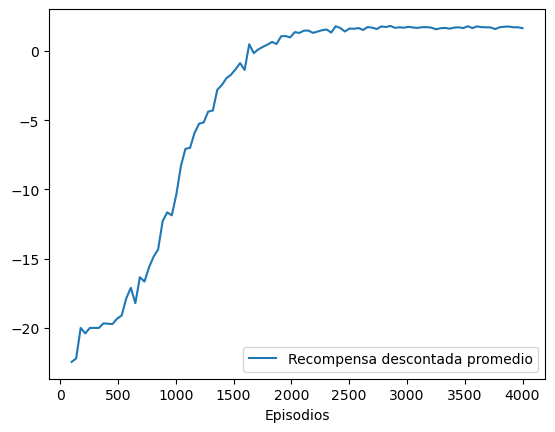

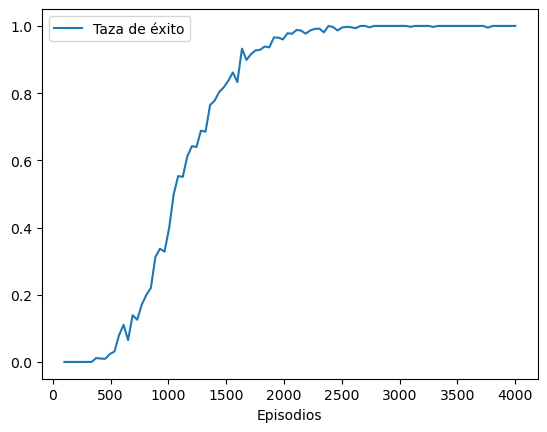

In [11]:
data.plot("Episodios","Recompensa descontada promedio")
data.plot("Episodios","Taza de éxito")

In [12]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context("notebook")

Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif


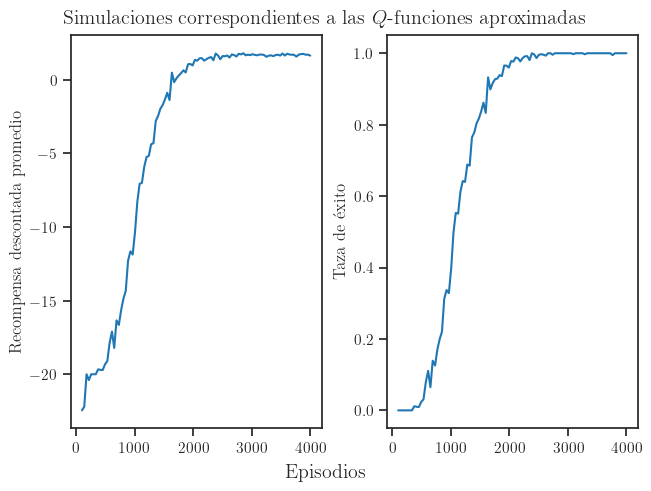

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', sharex=True)
plt.rcParams.update({"text.usetex": True,"font.family": "Computer Modern Serif"})
ax1.plot(data["Episodios"], data["Recompensa descontada promedio"])
ax1.set_ylabel("Recompensa descontada promedio")

ax2.plot(data["Episodios"], data["Taza de éxito"])
ax2.set_ylabel("Taza de éxito")

fig.supxlabel("Episodios")

fig.suptitle("Simulaciones correspondientes a las $Q$-funciones aproximadas")

plt.savefig("taxi_sim.pdf", backend='pgf')
plt.show()
plt.close()